# Projeto – Apriori

Um **marketplace** deseja construir um **sistema mais eficiente de recomendação de produtos** e, pra isso, quer usar um recorte do histórico de transações realizadas pelos clientes. Este histórico de transações contém informações como o departamento do produto comprado e a quantidade de itens comprados.

Desta forma, para que seja possível desenvolver este sistema, iremos realizar uma análise de *market basket* através do **algoritmo Apriori** que irá nos gerar algumas regras de associação que podem ser utilizadas para este modelo de recomendação.

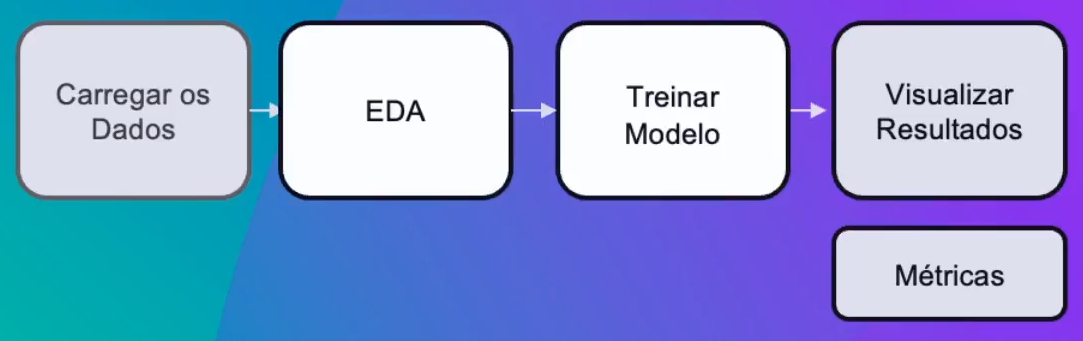

In [2]:
# EDA e visualizacao de dados
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from mlxtend.frequent_patterns import apriori, association_rules

### Carregar os dados

In [3]:
# carregar os dados no df
df_transacoes = pd.read_csv('./datasets/transaction_by_dept.csv')

In [4]:
# visualizar estrutura
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4539 entries, 0 to 4538
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   POS Txn  4539 non-null   uint64
 1   Dept     4539 non-null   object
 2   ID       4539 non-null   int64 
 3   Sales U  4539 non-null   int64 
dtypes: int64(2), object(1), uint64(1)
memory usage: 142.0+ KB


In [5]:
# visualizar os primeiros registros
df_transacoes.head(10)

,POS Txn,Dept,ID,Sales U
0,16120100160021008773,0261:HOSIERY,250,2
1,16120100160021008773,0634:VITAMINS & HLTH AIDS,102,1
2,16120100160021008773,0879:PET SUPPLIES,158,2
3,16120100160021008773,0973:CANDY,175,2
4,16120100160021008773,0982:SPIRITS,176,1
5,16120100160021008773,0983:WINE,177,4
6,16120100160021008773,0991:TOBACCO,179,2
7,16120100160021008774,0597:HEALTH AIDS,93,1
8,16120100160021008774,0604:PERSONAL CARE,100,5
9,16120100160021008775,0819:PRE-RECORDED A/V,135,1


In [6]:
# visualizar os ultimos registros
df_transacoes.tail(10)

,POS Txn,Dept,ID,Sales U
4529,16120100160162000841,0857:PC PERIPH/OFFICE ACC,155,1
4530,16120100160162000841,0931:BATH,165,1
4531,16120100160162000841,0941:BEDDING,167,1
4532,16120100160162000841,0991:TOBACCO,179,1
4533,16120100160162000842,0815:AUDIO ELECTRONICS,132,1
4534,16120100160162000843,0857:PC PERIPH/OFFICE ACC,155,1
4535,16120100160162000845,0395:MENS ATHLETIC SHOES,49,1
4536,16120100160162000845,0815:AUDIO ELECTRONICS,132,1
4537,16120100160162000846,0532:AMERICAN GREETINGS,72,1
4538,16120100160221001467,0066:VENDING/AMUSEMENT MA,242,1


### EDA

In [7]:
# renomear colunas para facilitar o entendimento
df_transacoes.rename(columns={'POS Txn': 'ID_Transacao', 'Dept': 'Departamento',
                              'ID': 'ID_Departamento', 'Sales U': 'Qtde_Vendida'}, inplace=True)

In [8]:
# visualizar estrutura
df_transacoes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4539 entries, 0 to 4538
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID_Transacao     4539 non-null   uint64
 1   Departamento     4539 non-null   object
 2   ID_Departamento  4539 non-null   int64 
 3   Qtde_Vendida     4539 non-null   int64 
dtypes: int64(2), object(1), uint64(1)
memory usage: 142.0+ KB


In [9]:
# quantidade de departamentos
df_transacoes['Departamento'].nunique()

160

In [10]:
# quantidade de id departamentos
df_transacoes['ID_Departamento'].nunique()

160

In [11]:
# quantidade de transacoes
df_transacoes['ID_Transacao'].nunique()

2064

In [12]:
# um departamento pode aparecer mais de uma vez na mesma transacao?
(len(df_transacoes.groupby(['ID_Transacao', 'Departamento'])) != len(df_transacoes))

False

In [13]:
# checar se ha quantidades negativas e iguais a zero
len(df_transacoes[df_transacoes['Qtde_Vendida'] <= 0]) 

149

In [14]:
# remover as linhas com quantidades vendidas <= 0
df_transacoes = df_transacoes[df_transacoes['Qtde_Vendida'] > 0] 

In [15]:
# quais departamentos tem o maior volume de transacoes e maior quantidade de unidades vendidas?
# parte 1: volume de transacoes

# quantidade de transacoes unicas onde cada departamento aparece
contagem_transacoes_por_departamento = df_transacoes.value_counts('Departamento')

# plot
fig_volume_transacoes = px.bar(contagem_transacoes_por_departamento, color=contagem_transacoes_por_departamento.index, orientation='h')
fig_volume_transacoes.update_layout(showlegend=False)
fig_volume_transacoes.show()

In [16]:
# quail o top 10 de departamentos tem o maior volume de transacoes e maior quantidade de unidades vendidas?
# parte 1: volume de transacoes

# quantidade de transacoes unicas onde cada departamento aparece
contagem_transacoes_por_departamento_top10 = df_transacoes.value_counts('Departamento').head(10)

# plot
fig_volume_transacoes_top10 = px.bar(contagem_transacoes_por_departamento_top10, color=contagem_transacoes_por_departamento_top10.index, orientation='h')
fig_volume_transacoes_top10.update_layout(showlegend=False)
fig_volume_transacoes_top10.show()

In [17]:
# quais departamentos tem o maior volume de transacoes e maior quantidade de unidades vendidas?
# parte 2: quantidade de unidades vendidas

# soma de unidades vendidas das transacoes onde cada departamento aparece
soma_quantidades_por_departamento = df_transacoes.groupby('Departamento')['Qtde_Vendida'].sum().sort_values(ascending=False)

# plot
fig_unidades_vendidas = px.bar(soma_quantidades_por_departamento, color=soma_quantidades_por_departamento.index, orientation='h')
fig_unidades_vendidas.update_layout(showlegend=False)
fig_unidades_vendidas.show()

In [18]:
# qual o top 10 de departamentos tem o maior volume de transacoes e maior quantidade de unidades vendidas?
# parte 2: quantidade de unidades vendidas

# soma de unidades vendidas das transacoes onde cada departamento aparece
soma_quantidades_por_departamento_top10 = df_transacoes.groupby('Departamento')['Qtde_Vendida'].sum().sort_values(ascending=False).head(10)

# plot
fig_unidades_vendidas_top10 = px.bar(soma_quantidades_por_departamento_top10, color=soma_quantidades_por_departamento_top10.index, orientation='h')
fig_unidades_vendidas_top10.update_layout(showlegend=False)
fig_unidades_vendidas_top10.show()

In [19]:
# unificar dois graficos (top 10), para mostrar lado a lado

# criar subplots
fig_pergunta_1 = make_subplots(rows=1, cols=2, subplot_titles=('Volume de Transações', 'Unidades Vendidas'))

# adicionar os graficos aos subplots
for trace in fig_volume_transacoes_top10['data']:
    fig_pergunta_1.add_trace(trace, row=1, col=1)

for trace in fig_unidades_vendidas_top10['data']:
    fig_pergunta_1.add_trace(trace, row=1, col=2)

# atualizar layout
fig_pergunta_1.update_layout(height=800, width=1000, title_text='Top10 Departamentos', showlegend=False)

# mostrar o grafico
fig_pergunta_1.show()

In [20]:
# quais departamentos tem a maior variacao nas unidades vendidas por transacao? top 20

# calcular o desvio padrao das quantidades vendidas, agrupando por departamento

# soma de unidades vendidas das transacoes onde cada departamento aparece
desvio_padrao_quantidades_por_departamento_top20 = df_transacoes.groupby('Departamento')['Qtde_Vendida'].std().sort_values(ascending=False).head(20)

# plot
fig_variacao_unidades_vendidas_top20 = px.bar(desvio_padrao_quantidades_por_departamento_top20, color=desvio_padrao_quantidades_por_departamento_top20.index, orientation='h')
fig_variacao_unidades_vendidas_top20.update_layout(showlegend=False)
fig_variacao_unidades_vendidas_top20.show()

In [21]:
# qual é a distribuicao de unidades vendidas por departamento nas diferentes transacoes?

# avaliar as medidas de posicoes da variavel quantidade vendida
px.box(df_transacoes, x='Departamento', y='Qtde_Vendida')

In [22]:
# quais departamentos tem a maior media nas unidades vendidas por transacao? top 20

# calcular a media das quantidades vendidas, agrupando por departamento

# soma de unidades vendidas das transacoes onde cada departamento aparece
media_quantidades_por_departamento_top20 = df_transacoes.groupby('Departamento')['Qtde_Vendida'].mean().sort_values(ascending=False).head(20)

# plot
fig_media_unidades_vendidas_top20 = px.bar(media_quantidades_por_departamento_top20, color=media_quantidades_por_departamento_top20.index, orientation='h')
fig_media_unidades_vendidas_top20.update_layout(showlegend=False)
fig_media_unidades_vendidas_top20.show()

In [23]:
# unificar dois graficos (top 10), para mostrar lado a lado

# criar subplots
fig_pergunta_4 = make_subplots(rows=1, cols=2, subplot_titles=('Desvio Padrão', 'Média'))

# adicionar os graficos aos subplots
for trace in fig_variacao_unidades_vendidas_top20['data']:
    fig_pergunta_4.add_trace(trace, row=1, col=1)

for trace in fig_media_unidades_vendidas_top20['data']:
    fig_pergunta_4.add_trace(trace, row=1, col=2)

# atualizar layout
fig_pergunta_4.update_layout(height=800, width=1000, title_text='Top20 Departamentos - Unidades Vendidas', showlegend=False)

# mostrar o grafico
fig_pergunta_4.show()

### Preparação da Base com Pivot Table

| ID_Trans | Prod1 | Prod2 | Prod3 | Prod4 |
|----------|--------|--------|--------|--------|
| 0000001  |   X    |        |   X    |        |
| 0000002  |   X    |   X    |   X    |        |
| 0000003  |        |        |   X    |   X    |

In [25]:
# criar uma pivot table no pandas com id_transacao como linha e departamento como coluna, soma de quantidade vendida como valor
df_transacoes_pivot = df_transacoes.pivot_table(index='ID_Transacao', 
                                                columns='Departamento', 
                                                values='Qtde_Vendida',
                                                aggfunc='sum')

In [26]:
# verificar estrutura pivot table
df_transacoes_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1943 entries, 16120100160021008773 to 16120100160221001467
Columns: 156 entries, 0002:BARBER RETAIL to 0999:UNSCANNED ITEMS
dtypes: float64(156)
memory usage: 2.3 MB


In [35]:
# verificar os primeiros registros
df_transacoes_pivot.head(20)

,0002:BARBER RETAIL,0009:FLORAL SERV/SUPPLIES,0012:LOCAL GIFTS/FOODS,0014:REPAIRS,0016:FINANCIAL SERVICES,0018:OTHER DIRECT SERVICE,0033:VENDING RETAIL,0056:SOUVENIR,0066:VENDING/AMUSEMENT MA,0071:BEAUTY RETAIL,...,0941:BEDDING,0961:GENERAL GROCERIES,0962:BEVERAGES,0965:PERISHABLES,0973:CANDY,0982:SPIRITS,0983:WINE,0984:BEER,0991:TOBACCO,0999:UNSCANNED ITEMS
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,True,True,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,True,False,False,False
9,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False


In [29]:
# converter os dados da pivot table para booleano (true ou false)
df_transacoes_pivot = df_transacoes_pivot.map(lambda x: True if x > 0 else False)

In [31]:
# remover o titulo departamento
df_transacoes_pivot = df_transacoes_pivot.rename_axis(None, axis=1)

In [33]:
# dropar / remover a coluna id transacao (index)
df_transacoes_pivot.reset_index(inplace=True)

In [34]:
# remover coluna id transacao
df_transacoes_pivot.drop(columns=['ID_Transacao'], axis=1, inplace=True)

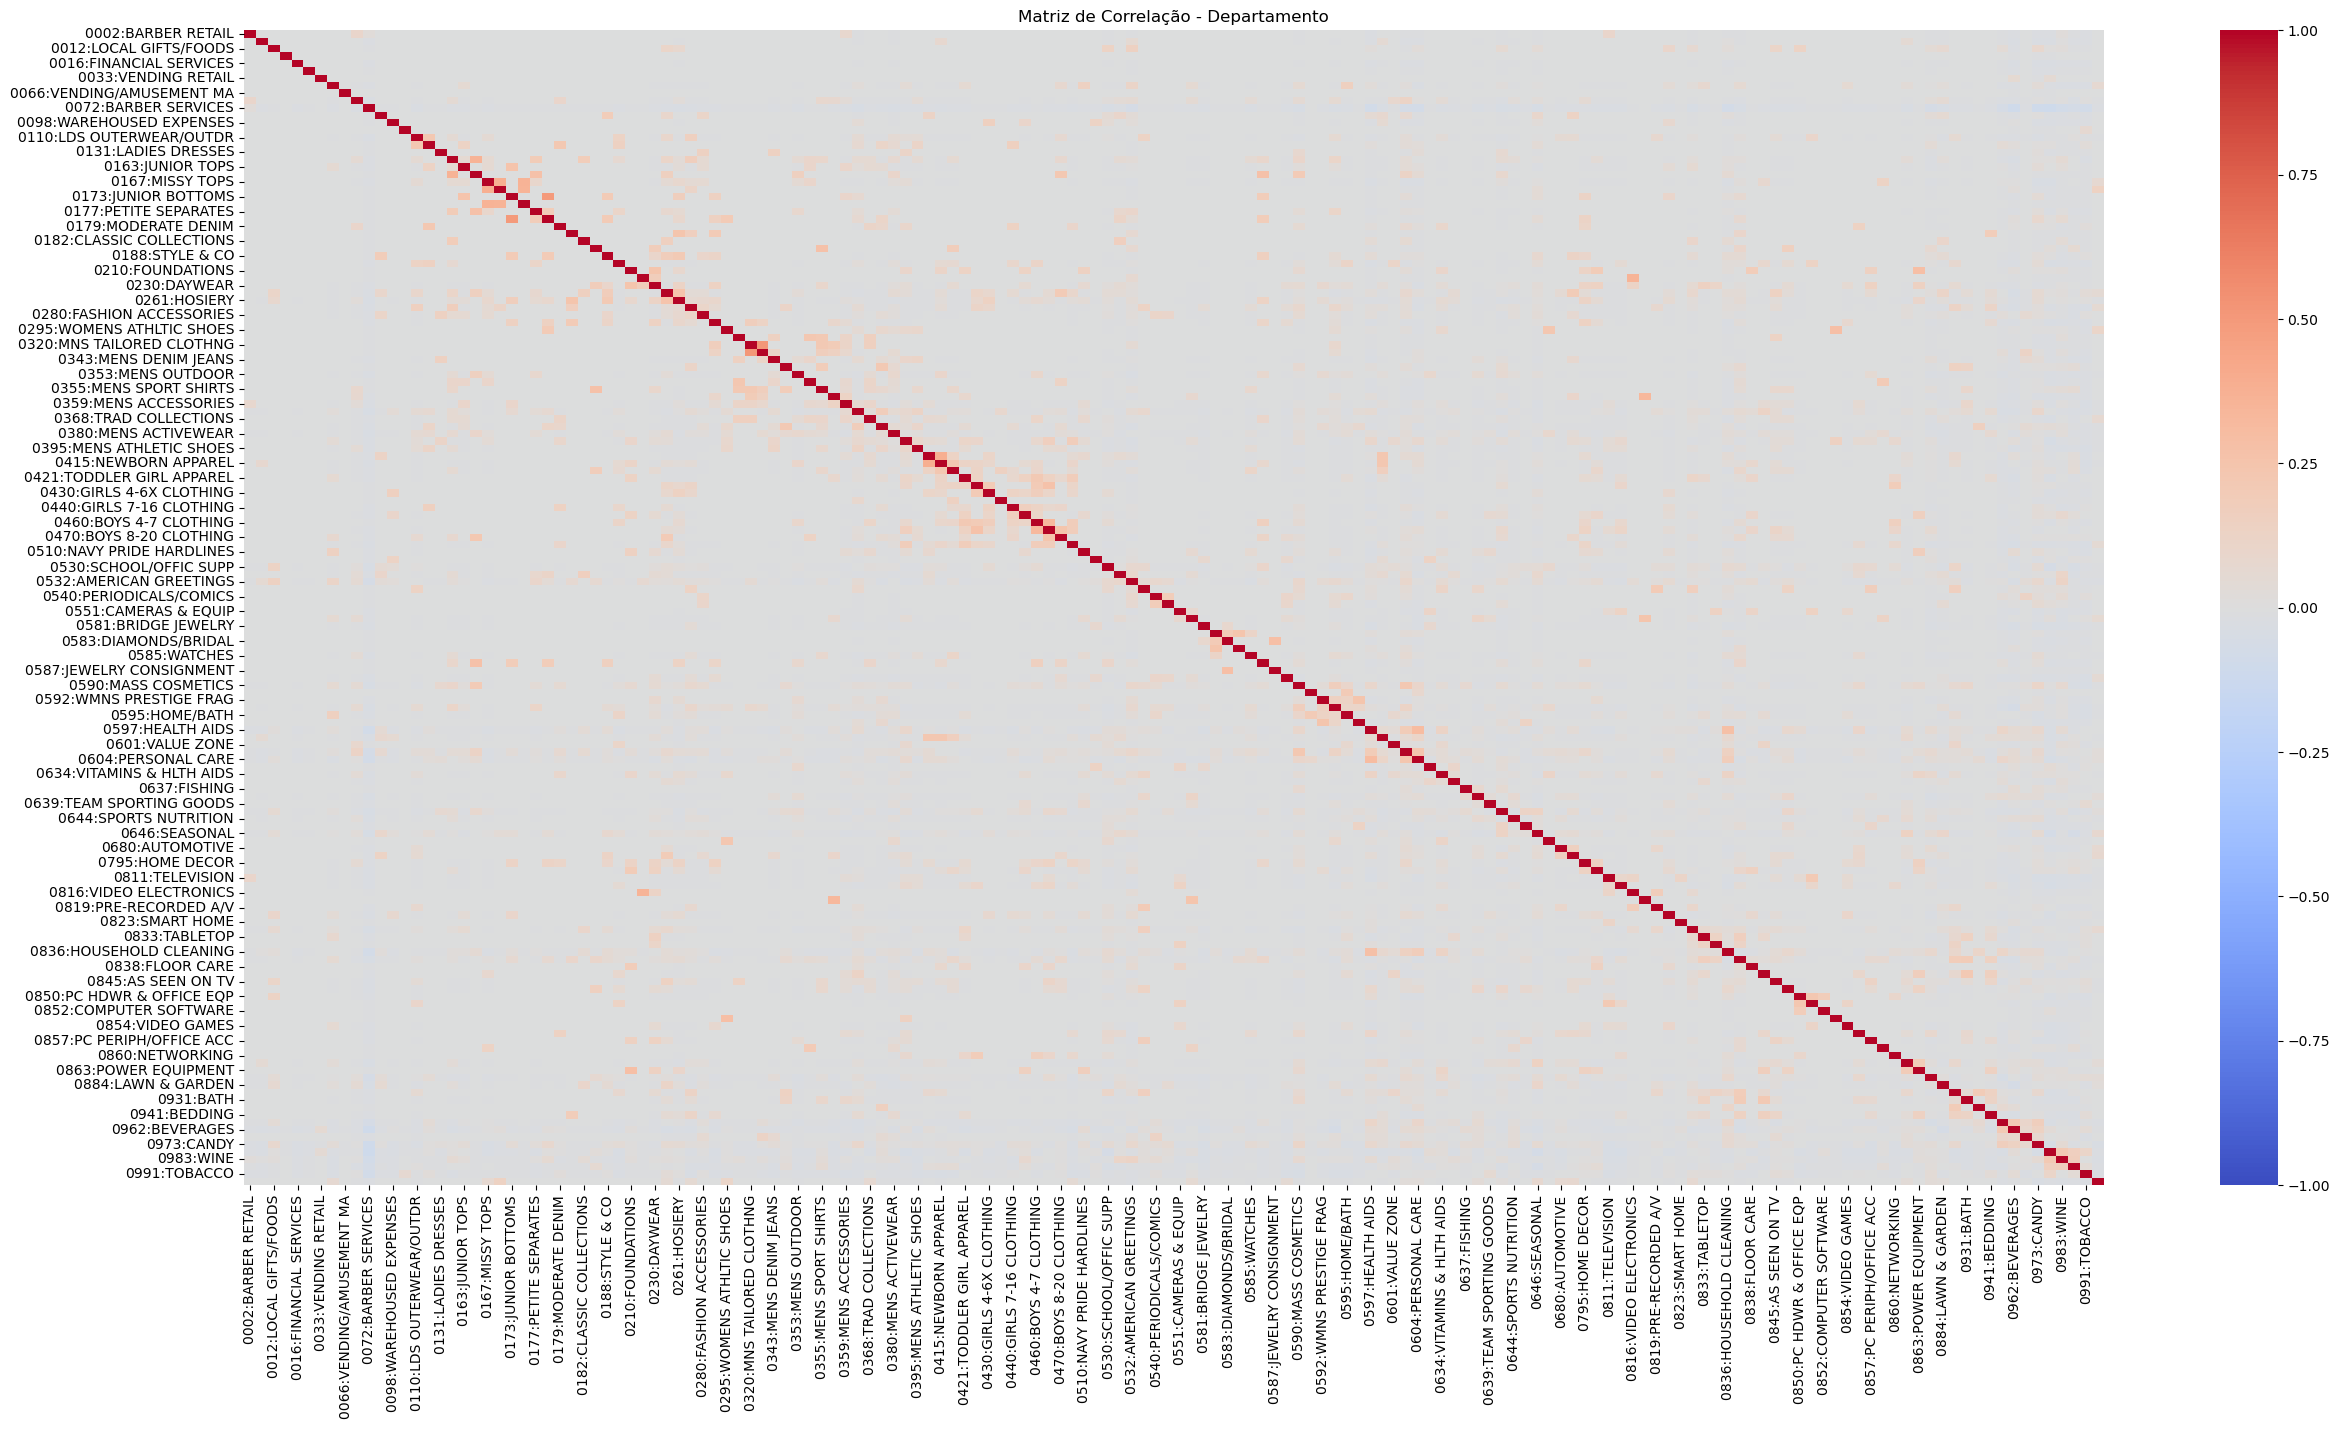

In [37]:
# qual a correlacao entre os departamentos
associacao_departamentos = df_transacoes_pivot.corr()
plt.figure(figsize=(30,15))
sns.heatmap(associacao_departamentos, cmap='coolwarm', annot=False, vmin=-1, vmax=1)
plt.title('Matriz de Correlação - Departamento')
plt.show()

### Realizar Market Basket Analysis com Apriori

In [38]:
# obter uma lista de itemsets frequentes

# suporte que seja em 2% a 5%
# cobertura adequada = 40 a 100 transacoes
# diversidade de departamentos, sem ser muito restritivo

itemsets_frequentes = apriori(df_transacoes_pivot, min_support=0.02, use_colnames=True, verbose=1)

Processing 165 combinations | Sampling itemset size 3


In [39]:
# quantos itemsets foram selecionados
len(itemsets_frequentes)

36

In [40]:
# criar uma coluna para armazenar o tamanho do itemset
itemsets_frequentes['tamanho'] = itemsets_frequentes['itemsets'].apply(lambda x: len(x))

In [41]:
# quais sao estes itemsets?
itemsets_frequentes

,support,itemsets,tamanho
0,0.057643,(0072:BARBER SERVICES),1
1,0.024704,(0360:MENS FURNISHINGS),1
2,0.024189,(0380:MENS ACTIVEWEAR),1
3,0.027277,(0530:SCHOOL/OFFIC SUPP),1
4,0.053011,(0532:AMERICAN GREETINGS),1
5,0.026248,(0590:MASS COSMETICS),1
6,0.022645,(0593:PRESTIGE COSMETICS),1
7,0.102934,(0597:HEALTH AIDS),1
8,0.067936,(0603:BEAUTY CARE),1
9,0.077200,(0604:PERSONAL CARE),1


In [42]:
# filtrar itemsets com 2 departamentos
itemsets_frequentes[itemsets_frequentes.tamanho == 2]

,support,itemsets,tamanho
24,0.021616,"(0603:BEAUTY CARE, 0597:HEALTH AIDS)",2
25,0.032939,"(0604:PERSONAL CARE, 0597:HEALTH AIDS)",2
26,0.031395,"(0597:HEALTH AIDS, 0836:HOUSEHOLD CLEANING)",2
27,0.023160,"(0973:CANDY, 0597:HEALTH AIDS)",2
28,0.021101,"(0604:PERSONAL CARE, 0603:BEAUTY CARE)",2
29,0.022131,"(0961:GENERAL GROCERIES, 0962:BEVERAGES)",2
30,0.020072,"(0973:CANDY, 0961:GENERAL GROCERIES)",2
31,0.034483,"(0973:CANDY, 0962:BEVERAGES)",2
32,0.025219,"(0962:BEVERAGES, 0982:SPIRITS)",2
33,0.039629,"(0983:WINE, 0982:SPIRITS)",2


In [44]:
# Validar a informação de Suporte. Ex: 0982:SPIRITS
# Suporte = transações onde o itemset aparece / total de transações

transacoes_spirits = len(df_transacoes_pivot[df_transacoes_pivot['0982:SPIRITS'] == True])
total_transacoes = len(df_transacoes_pivot)
suporte_spirits = transacoes_spirits / total_transacoes
print(f'Suporte 0982:SPIRITS {suporte_spirits}')

Suporte 0982:SPIRITS 0.16160576428203807


In [50]:
# Criar Regras de Associação, com base nos itemsets frequentes
# Usando Confiança = 30%

regras_associacao = association_rules(itemsets_frequentes, metric='conviction', min_threshold=1.4)
regras_associacao

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(0604:PERSONAL CARE),(0597:HEALTH AIDS),0.077200,0.102934,0.032939,0.426667,4.145067,1.0,0.024992,1.564651,0.822225,0.223776,0.360880,0.373333
1,(0836:HOUSEHOLD CLEANING),(0597:HEALTH AIDS),0.081318,0.102934,0.031395,0.386076,3.750728,1.0,0.023024,1.461201,0.798301,0.205387,0.315631,0.345538
2,(0961:GENERAL GROCERIES),(0962:BEVERAGES),0.050952,0.130211,0.022131,0.434343,3.335689,1.0,0.015496,1.537663,0.737805,0.139159,0.349662,0.302152
3,(0961:GENERAL GROCERIES),(0973:CANDY),0.050952,0.141534,0.020072,0.393939,2.783361,1.0,0.012861,1.416469,0.675121,0.116418,0.294019,0.267879
4,(0983:WINE),(0982:SPIRITS),0.098302,0.161606,0.039629,0.403141,2.494598,1.0,0.023743,1.404678,0.664450,0.179907,0.288093,0.324182
